# 项目需求：通过XGboost来实现预测zclose值

# 导入各python包

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

# 导入数据

In [3]:
all_data_set_path = r'csv_export\csv_data_1m_begin_40d_博22转债_SHSE.113650_SHSE.603916.csv'
all_data_set = pd.read_csv(all_data_set_path)

In [4]:
print(all_data_set.head())

                 index   zopen   zhigh    zlow      zclose  zvolume  sopen  \
0  2022-07-28 09:31:00  122.10  122.10  122.10  122.099998   142400  20.43   
1  2022-07-28 10:01:00  122.10  124.72  122.10  124.519997   183720  20.58   
2  2022-07-28 10:02:00  124.55  125.10  123.68  123.680000   171690  20.53   
3  2022-07-28 10:03:00  123.88  124.24  123.61  124.160004   177300  20.54   
4  2022-07-28 10:04:00  124.35  124.35  123.60  123.879997   146450  20.55   

   shigh   slow     sclose  svolume        scv  
0  20.53  20.40  20.410000    77050  85.219206  
1  20.58  20.53  20.570000     4934  85.887264  
2  20.55  20.53  20.540001     6200  85.762008  
3  20.55  20.53  20.549999     7300  85.803755  
4  20.56  20.55  20.559999     4200  85.845509  


In [9]:
print(all_data_set.info()) #查看有多少数据及特征

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    1546 non-null   object 
 1   zopen    1546 non-null   float64
 2   zhigh    1546 non-null   float64
 3   zlow     1546 non-null   float64
 4   zclose   1546 non-null   float64
 5   zvolume  1546 non-null   int64  
 6   sopen    1546 non-null   float64
 7   shigh    1546 non-null   float64
 8   slow     1546 non-null   float64
 9   sclose   1546 non-null   float64
 10  svolume  1546 non-null   int64  
 11  scv      1546 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 145.1+ KB
None


In [10]:
print(all_data_set.isnull().sum()) #检查是否有空数据

index      0
zopen      0
zhigh      0
zlow       0
zclose     0
zvolume    0
sopen      0
shigh      0
slow       0
sclose     0
svolume    0
scv        0
dtype: int64


# 研究数据

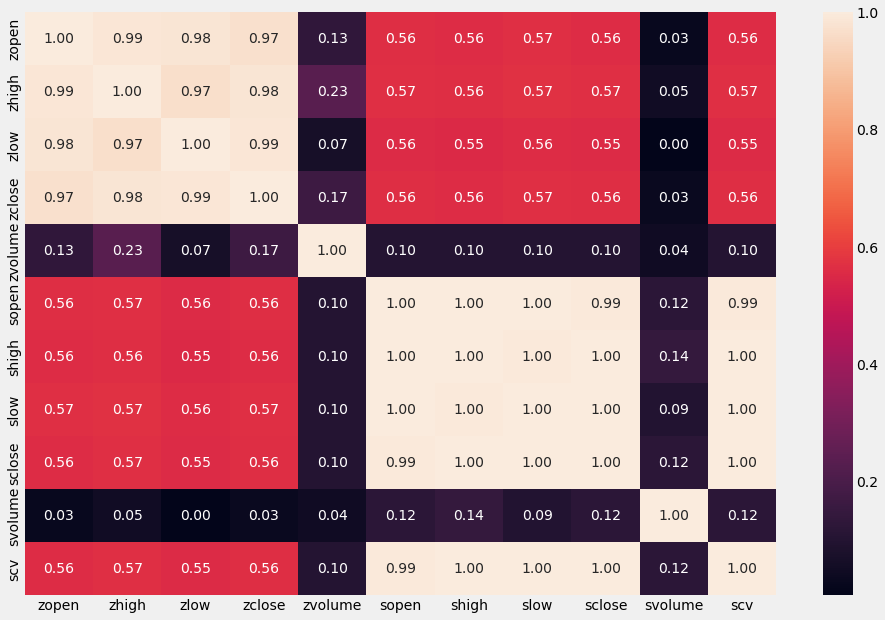

In [5]:
# 特征热力图 相关性分析
list_columns = all_data_set.columns
plt.figure(figsize=(15,10))
sns.heatmap(all_data_set[list_columns].corr(), annot=True, fmt=".2f")
plt.show()

In [6]:
# 对特征重要性进行排序
corr_1 = all_data_set.corr()
corr_1["zclose"].sort_values(ascending=False)

zclose     1.000000
zlow       0.985912
zhigh      0.984374
zopen      0.972496
slow       0.568228
sopen      0.563596
sclose     0.563588
scv        0.563588
shigh      0.559682
zvolume    0.167665
svolume    0.028657
Name: zclose, dtype: float64

# 数据预处理

In [16]:
len_ = len(['zopen','zhigh','zlow','zclose'])*3
col_numbers_drop = []
for i in range(3):
    col_numbers_drop.append(len_+i)
print(col_numbers_drop)

[12, 13, 14]


In [14]:
all_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    1546 non-null   object 
 1   zopen    1546 non-null   float64
 2   zhigh    1546 non-null   float64
 3   zlow     1546 non-null   float64
 4   zclose   1546 non-null   float64
 5   zvolume  1546 non-null   int64  
 6   sopen    1546 non-null   float64
 7   shigh    1546 non-null   float64
 8   slow     1546 non-null   float64
 9   sclose   1546 non-null   float64
 10  svolume  1546 non-null   int64  
 11  scv      1546 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 145.1+ KB


In [49]:
# 依据特征重要性，选择zlow zhigh zopen来进行预测zclose
# 数据选择t-n, ...., t-2 t-1 与 t 来预测未来 t+1
# 转换原始数据为新的特征列来进行预测,time_window可以用来调试用前几次的数据来预测
def series_to_supervised(data,time_window=3):
    data_columns = ['zopen','zhigh','zlow','zclose']
    data = data[data_columns]  # Note this is important to the important feature choice
    cols, names = list(), list()
    for i in range(time_window, -1, -1):
        # get the data
        cols.append(data.shift(i)) #数据偏移量
        
        # get the column name
        if ((i-1)<=0):
            suffix = '(t+%d)'%abs(i-1)
        else:
            suffix = '(t-%d)'%(i-1)
        names += [(colname + suffix) for colname in data_columns]
        
    # concat the cols into one dataframe
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    agg.index = data.index.copy()
    # remove the nan value which is caused by pandas.shift
    agg = agg.dropna(inplace=False)

    # remove unused col (only keep the "close" fied for the t+1 period)
    # Note col "close" place in the columns

    len_ = len(data_columns)*time_window
    col_numbers_drop = []
    for i in range(len(data_columns)-1):
        col_numbers_drop.append(len_+i)

    agg.drop(agg.columns[col_numbers_drop],axis=1,inplace = True)
       
    return agg
    

In [56]:
all_data_set2 = all_data_set.copy()
all_data_set2["index"] = pd.to_datetime(all_data_set2["index"])       # 日期object: to datetime
all_data_set2.set_index("index", inplace=True, drop=True) # 把index设为索引

In [57]:
all_data_set2 = all_data_set2[116:] # 这里把7月28日的数据全部删掉了，主要是数据缺失较多

In [59]:
data_set_process = series_to_supervised(all_data_set2,10) #取近10分钟的数据
print(data_set_process.columns.values)

array(['zopen(t-9)', 'zhigh(t-9)', 'zlow(t-9)', 'zclose(t-9)',
       'zopen(t-8)', 'zhigh(t-8)', 'zlow(t-8)', 'zclose(t-8)',
       'zopen(t-7)', 'zhigh(t-7)', 'zlow(t-7)', 'zclose(t-7)',
       'zopen(t-6)', 'zhigh(t-6)', 'zlow(t-6)', 'zclose(t-6)',
       'zopen(t-5)', 'zhigh(t-5)', 'zlow(t-5)', 'zclose(t-5)',
       'zopen(t-4)', 'zhigh(t-4)', 'zlow(t-4)', 'zclose(t-4)',
       'zopen(t-3)', 'zhigh(t-3)', 'zlow(t-3)', 'zclose(t-3)',
       'zopen(t-2)', 'zhigh(t-2)', 'zlow(t-2)', 'zclose(t-2)',
       'zopen(t-1)', 'zhigh(t-1)', 'zlow(t-1)', 'zclose(t-1)',
       'zopen(t+0)', 'zhigh(t+0)', 'zlow(t+0)', 'zclose(t+0)',
       'zclose(t+1)'], dtype=object)

In [60]:
print(data_set_process.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1420 entries, 2022-07-29 09:41:00 to 2022-08-05 15:00:00
Data columns (total 41 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   zopen(t-9)   1420 non-null   float64
 1   zhigh(t-9)   1420 non-null   float64
 2   zlow(t-9)    1420 non-null   float64
 3   zclose(t-9)  1420 non-null   float64
 4   zopen(t-8)   1420 non-null   float64
 5   zhigh(t-8)   1420 non-null   float64
 6   zlow(t-8)    1420 non-null   float64
 7   zclose(t-8)  1420 non-null   float64
 8   zopen(t-7)   1420 non-null   float64
 9   zhigh(t-7)   1420 non-null   float64
 10  zlow(t-7)    1420 non-null   float64
 11  zclose(t-7)  1420 non-null   float64
 12  zopen(t-6)   1420 non-null   float64
 13  zhigh(t-6)   1420 non-null   float64
 14  zlow(t-6)    1420 non-null   float64
 15  zclose(t-6)  1420 non-null   float64
 16  zopen(t-5)   1420 non-null   float64
 17  zhigh(t-5)   1420 non-null   float64
 18  zlow(t-5)   

In [61]:
print(data_set_process.head())

                     zopen(t-9)  zhigh(t-9)  zlow(t-9)  zclose(t-9)  \
index                                                                 
2022-07-29 09:41:00      125.00      125.01     124.21   124.690002   
2022-07-29 09:42:00      124.72      125.11     124.66   125.099998   
2022-07-29 09:43:00      125.10      125.28     125.10   125.180000   
2022-07-29 09:44:00      125.20      125.20     124.65   124.650002   
2022-07-29 09:45:00      124.66      124.90     124.66   124.900002   

                     zopen(t-8)  zhigh(t-8)  zlow(t-8)  zclose(t-8)  \
index                                                                 
2022-07-29 09:41:00      124.72      125.11     124.66   125.099998   
2022-07-29 09:42:00      125.10      125.28     125.10   125.180000   
2022-07-29 09:43:00      125.20      125.20     124.65   124.650002   
2022-07-29 09:44:00      124.66      124.90     124.66   124.900002   
2022-07-29 09:45:00      124.90      125.20     124.90   125.169998   

    

# 搭建模型XGboost

In [145]:
train_size = int(len(data_set_process)*0.8)
test_size = len(data_set_process) - train_size
train_XGB, test_XGB = scaled_data[0:train_size,:],scaled_data[train_size:len(data_set_process),:]

train_XGB_X, train_XGB_Y = train_XGB[:,:(len(data_set_process.columns)-1)],train_XGB[:,(len(data_set_process.columns)-1)]
test_XGB_X, test_XGB_Y = test_XGB[:,:(len(data_set_process.columns)-1)],test_XGB[:,(len(data_set_process.columns)-1)]


In [149]:
test_XGB_Y[0:10]

array([0.40985157, 0.40985157, 0.40985157, 0.40985157, 0.41050928,
       0.41050928, 0.41132985, 0.41116573, 0.41116573, 0.41116573])

In [174]:
# 算法参数
params = {
    'booster':'gbtree',
    'objective':'binary:logistic',  # 此处为回归预测，这里如果改成multi:softmax 则可以进行多分类
    'gamma':0.1,
    'max_depth':5,
    'lambda':3,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'slient':1,
    'eta':0.1,
    'seed':1000,
    'nthread':4,
}

In [179]:
#生成数据集格式
xgb_train = xgb.DMatrix(train_XGB_X,label = train_XGB_Y)
xgb_test = xgb.DMatrix(test_XGB_X,label = test_XGB_Y)
num_rounds = 300
watchlist = [(xgb_test,'eval'),(xgb_train,'train')]

In [180]:
#xgboost模型训练
model_xgb = xgb.train(params,xgb_train,num_rounds,watchlist)

[14:50:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "slient" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:50:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.69067	train-logloss:0.68740
[1]	eval-logloss:0.68894	train-logloss:0.68259
[2]	eval-logloss:0.68753	train-logloss:0.67853
[3]	eval-logloss:0.68638	train-logloss:0.67515
[4]	eval-logloss:0.68548	train-logloss:0.67234
[5]	eval-logloss:0.68461	train-logloss:0.67008
[6]	eval-logloss:0.683

[156]	eval-logloss:0.68113	train-logloss:0.65589
[157]	eval-logloss:0.68113	train-logloss:0.65589
[158]	eval-logloss:0.68113	train-logloss:0.65589
[159]	eval-logloss:0.68113	train-logloss:0.65589
[160]	eval-logloss:0.68113	train-logloss:0.65589
[161]	eval-logloss:0.68113	train-logloss:0.65589
[162]	eval-logloss:0.68113	train-logloss:0.65589
[163]	eval-logloss:0.68113	train-logloss:0.65589
[164]	eval-logloss:0.68113	train-logloss:0.65589
[165]	eval-logloss:0.68113	train-logloss:0.65589
[166]	eval-logloss:0.68113	train-logloss:0.65589
[167]	eval-logloss:0.68113	train-logloss:0.65589
[168]	eval-logloss:0.68113	train-logloss:0.65589
[169]	eval-logloss:0.68113	train-logloss:0.65589
[170]	eval-logloss:0.68113	train-logloss:0.65589
[171]	eval-logloss:0.68113	train-logloss:0.65589
[172]	eval-logloss:0.68113	train-logloss:0.65587
[173]	eval-logloss:0.68113	train-logloss:0.65587
[174]	eval-logloss:0.68113	train-logloss:0.65587
[175]	eval-logloss:0.68113	train-logloss:0.65587
[176]	eval-logloss:0

In [184]:
#对测试集进行预测
y_pred_xgb = model_xgb.predict(xgb_test)

In [188]:
y_pred_xgb.shape

(284,)

In [185]:
y_pred_xgb

array([0.41153663, 0.41153663, 0.41153663, 0.41153663, 0.41153663,
       0.41153663, 0.41153663, 0.41153663, 0.41153663, 0.41153663,
       0.41153663, 0.41153663, 0.41153663, 0.41153663, 0.41153663,
       0.41153663, 0.41153663, 0.41153663, 0.41153663, 0.41153663,
       0.41153663, 0.41153663, 0.41153663, 0.41153663, 0.41153663,
       0.4023256 , 0.3970279 , 0.3970279 , 0.3970279 , 0.3970279 ,
       0.3970279 , 0.3970279 , 0.3970279 , 0.3970279 , 0.3970279 ,
       0.3970279 , 0.3970279 , 0.3970279 , 0.3970279 , 0.3970279 ,
       0.3970279 , 0.3970279 , 0.3970279 , 0.3970279 , 0.3970279 ,
       0.3970279 , 0.3970279 , 0.39254332, 0.3829697 , 0.38269016,
       0.3829697 , 0.38586026, 0.3910699 , 0.39254332, 0.3766345 ,
       0.37377098, 0.37377098, 0.37377098, 0.37377098, 0.37377098,
       0.36468905, 0.36468905, 0.36468905, 0.36468905, 0.36468905,
       0.36468905, 0.36468905, 0.36468905, 0.36468905, 0.36468905,
       0.37377098, 0.37377098, 0.3766345 , 0.3766345 , 0.38586

In [183]:
test_XGB_Y

array([0.40985157, 0.40985157, 0.40985157, 0.40985157, 0.41050928,
       0.41050928, 0.41132985, 0.41116573, 0.41116573, 0.41116573,
       0.41149396, 0.41116573, 0.41116573, 0.41050928, 0.40985157,
       0.40985157, 0.40985157, 0.40985157, 0.40985157, 0.40985157,
       0.40985157, 0.40985157, 0.40985157, 0.4072245 , 0.4006562 ,
       0.39737268, 0.39737268, 0.39753679, 0.39770091, 0.39770091,
       0.39753679, 0.39737268, 0.39737268, 0.39901507, 0.39737268,
       0.39737268, 0.39737268, 0.39737268, 0.39737268, 0.39753679,
       0.39737268, 0.39753679, 0.39753679, 0.39753679, 0.39737268,
       0.39802913, 0.3940879 , 0.36453119, 0.37422015, 0.36469655,
       0.36617357, 0.39375968, 0.39293911, 0.3665018 , 0.36502478,
       0.36486067, 0.36486067, 0.36469655, 0.36453119, 0.36124766,
       0.35796414, 0.35796414, 0.35796414, 0.35796414, 0.36075532,
       0.35796414, 0.35796414, 0.36124766, 0.36453119, 0.36469655,
       0.36453119, 0.36781596, 0.36880064, 0.37438426, 0.39408

In [189]:
test_XGB_Y.shape

(284,)

In [197]:
mape_xgb = np.mean(np.abs(y_pred_xgb-test_XGB_Y)/test_XGB_Y)*100
print('XGBoost平均误差率为：{}%'.format(mape_xgb))  #平均误差率为1.1974%

XGBoost平均误差率为：1.1974021974188707%


# 搭建模型LSTM网络

In [62]:
# 注意这里要安装Tensorflow 和 Keras才能使用
from keras.models import Sequential
from keras.layers import Dense,LSTM

ModuleNotFoundError: No module named 'keras'

In [66]:
data_set_process.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1420 entries, 2022-07-29 09:41:00 to 2022-08-05 15:00:00
Data columns (total 41 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   zopen(t-9)   1420 non-null   float64
 1   zhigh(t-9)   1420 non-null   float64
 2   zlow(t-9)    1420 non-null   float64
 3   zclose(t-9)  1420 non-null   float64
 4   zopen(t-8)   1420 non-null   float64
 5   zhigh(t-8)   1420 non-null   float64
 6   zlow(t-8)    1420 non-null   float64
 7   zclose(t-8)  1420 non-null   float64
 8   zopen(t-7)   1420 non-null   float64
 9   zhigh(t-7)   1420 non-null   float64
 10  zlow(t-7)    1420 non-null   float64
 11  zclose(t-7)  1420 non-null   float64
 12  zopen(t-6)   1420 non-null   float64
 13  zhigh(t-6)   1420 non-null   float64
 14  zlow(t-6)    1420 non-null   float64
 15  zclose(t-6)  1420 non-null   float64
 16  zopen(t-5)   1420 non-null   float64
 17  zhigh(t-5)   1420 non-null   float64
 18  zlow(t-5)   

In [67]:
len(data_set_process.columns)

41

In [82]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_set_process)

In [85]:
scaled_data.shape

(1420, 41)

In [86]:
train_size = int(len(data_set_process)*0.8)
test_size = len(data_set_process) - train_size
train_LSTM, test_LSTM = scaled_data[0:train_size,:],scaled_data[train_size:len(data_set_process),:]

train_LSTM_X, train_LSTM_Y = train_LSTM[:,:(len(data_set_process.columns)-1)],train_LSTM[:,(len(data_set_process.columns)-1)]
test_LSTM_X, test_LSTM_Y = test_LSTM[:,:(len(data_set_process.columns)-1)],test_LSTM[:,(len(data_set_process.columns)-1)]

# reshape input to be [samples, time steps, features]
train_LSTM_X = np.reshape(train_LSTM_X, (train_LSTM_X.shape[0],1,train_LSTM_X.shape[1]))
test_LSTM_X = np.reshape(test_LSTM_X, (test_LSTM_X.shape[0],1,test_LSTM_X.shape[1]))

print(train_LSTM_X.shape,train_LSTM_Y.shape,test_LSTM_X.shape,test_LSTM_Y.shape)

(1136, 1, 40) (1136,) (284, 1, 40) (284,)


In [103]:
type(scaler)

sklearn.preprocessing._data.MinMaxScaler

In [109]:
test_LSTM_X[:,:,-4:].shape

(284, 1, 4)

In [113]:
np.array(data_set_process[-284:]['zclose(t+1)']).shape

(284,)

In [91]:
test_LSTM_X.shape

(284, 1, 40)

# 结果可视化及评估

In [130]:
testPredict.flatten()

array([125.36691417, 125.36818646, 125.37166192, 125.37154068,
       125.36880735, 125.37171075, 125.37322043, 125.37646558,
       125.37735999, 125.37929909, 125.37894663, 125.37915226,
       125.37850832, 125.3779827 , 125.37595975, 125.37187427,
       125.36949504, 125.36943333, 125.36912624, 125.36954241,
       125.36973353, 125.36916545, 125.3700232 , 125.36974532,
       125.36391495, 125.33582626, 125.30894052, 125.29573215,
       125.28766737, 125.29242947, 125.29187373, 125.29210114,
       125.29423336, 125.29344476, 125.29799813, 125.29631167,
       125.29526062, 125.29654598, 125.29542978, 125.29474989,
       125.29392173, 125.29435478, 125.29556082, 125.29386946,
       125.29458782, 125.29480942, 125.29745527, 125.28852276,
       125.20020008, 125.14678779, 125.12954041, 125.13128894,
       125.17988051, 125.23011371, 125.17045487, 125.10302166,
       125.10755634, 125.0711279 , 125.10156334, 125.09282122,
       125.08844262, 125.06554817, 125.06194112, 125.05

In [142]:
np.array(data_set_process)[-284:,-1:].flatten()

array([125.29599762, 125.29599762, 125.29599762, 125.29599762,
       125.30000305, 125.30000305, 125.30500031, 125.30400085,
       125.30400085, 125.30400085, 125.30599976, 125.30400085,
       125.30400085, 125.30000305, 125.29599762, 125.29599762,
       125.29599762, 125.29599762, 125.29599762, 125.29599762,
       125.29599762, 125.29599762, 125.29599762, 125.27999878,
       125.23999786, 125.22000122, 125.22000122, 125.22100067,
       125.22200012, 125.22200012, 125.22100067, 125.22000122,
       125.22000122, 125.23000336, 125.22000122, 125.22000122,
       125.22000122, 125.22000122, 125.22000122, 125.22100067,
       125.22000122, 125.22100067, 125.22100067, 125.22100067,
       125.22000122, 125.22399902, 125.19999695, 125.01999664,
       125.07900238, 125.02100372, 125.02999878, 125.19799805,
       125.19300079, 125.03199768, 125.02300262, 125.02200317,
       125.02200317, 125.02100372, 125.01999664, 125.        ,
       124.98000336, 124.98000336, 124.98000336, 124.98

In [144]:
mape = np.mean(np.abs(np.array(data_set_process)[-284:,-1:].flatten()-testPredict.flatten())/np.array(data_set_process)[-284:,-1:].flatten())*100
print(mape)

0.06395090005149898


In [129]:
testPredict[1][0]

125.36818646

In [134]:
test_LSTM_Y.shape

(284,)

# 模型调优